In [8]:
import numpy as np
import matplotlib.pyplot as plt
import math
from ipywidgets import interact
import matplotlib.patches as matpatch
from descartes.patch import PolygonPatch
from shapely.ops import cascaded_union, polygonize
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
from scipy.integrate import quad, dblquad
from scipy import interpolate
import shapely.geometry as sg
import descartes
import sobol_seq
%matplotlib notebook

# Алгоритм Монте-Карло для нахождения площади сложной фигуры

<img src="2rpr.jpg">

https://www.researchgate.net/publication/245038755_Workspace_optimization_and_kinematic_performance_evaluation_of_2DOF_parallel_mechanisms

### Робот 2-RPR
Робот состоит из двух штанг переменной длинны и известно расстояние между основаниями штанг

Задача: найти площадь рабочей области робота и нарисовать её

In [2]:
def check_circ_lit(x, y, x0, y0, r):#проверяем лежит ли точка вне малой окр-ти
    """
    Check point if it is outside lower limit of leg (what is the same if these points outside the smallest circles)
    
    Parameters
    ----------
    x, y : float, the coordinates of points
    x0, y0 : float, the coordinates of the circle's center
    r : float, radius of the circle
    Returns
    -------
    Boolean massive of all points which are outside the smallest circles
    
    """
    return (((x - x0)**2 + (y - y0)**2) >= r**2)

In [3]:
def check_circ_big(x, y, x0, y0, r):#проверяем лежит ли точка вне малой окр-ти
    """
    Check points if it is inside the higher limit of leg (what is the same if these points inside the biggest circles)
    
    Parameters
    ----------
    x, y : float, the coordinates of points
    x0, y0 : float, the coordinates of the circle's center
    r : float, radius of the circle
    Returns
    -------
    Boolean massive of all points which are inside the biggest circles
    
    return ((x - x0)**2 + (y - y0)**2 <= r**2)
    
    """
    return ((x - x0)**2 + (y - y0)**2 <= r**2)

### Алгоритм Монте-Карло
1) Ограничим нашу рабочую область прямоугольником с известными сторонами

2) Заполним прямоугольник случайным образом $N$-точками

3) Площадь искомой области будет вычисляться по формуле: $S=\dfrac{(b-a)\cdot (c-d) \cdot  K}{N}$, где $a$ и $b$ - левая и правая границы интегрирования, $с$ и $d$ - верхняя и нижняя границы интегрирования, $K$ - кол-во точек, которые попали в искомую область

Все точки рабочей области должны удоволетворять условиям, что они вне малых окружностей и внутри больших окружностей

In [4]:
def Monte_Carlo(l1_l, l2_l, l1_h, l2_h, d, p, seed=1234):
    """ 
    Compute the area of 2-RPR robot's workspace with Monte Carlo method
    
    Parameters
    ----------
    l1_l, l2_l : float, the lowest limit of legs
    l1_h, l2_h : float, the highest limit of legs
    d : float, length between legs of the robot
    p : int, amount of points
    seed : int, seed for rng, default = 1234
    Returns
    -------
    area: float , area of 2-RPR robot's workspace
    Xl, Xh : float, X-axis limits for MC rectangle
    Yl, Yh : float, Y-axis limits for MC rectangle
    
    """
    prng = np.random.RandomState(seed)
    Xp = (-l2_h**2 + l1_h**2 + d**2)/(2*d)
    Yp = math.sqrt(l1_h**2 - Xp**2)
    if l1_h <= l2_h:
        Yh = l1_h
    else:
        Yh = l2_h
    Xl = d - l2_h
    Xh = l1_h+abs(d - l2_h)
    Yl = 0
    X = prng.uniform(Xl, Xh, size=p)
    Y = prng.uniform(Yl, Yh, size=p)
    c = 0
    c = sum((check_circ_lit(X, Y, 0, 0, l1_l)) & (check_circ_lit(X, Y, d, 0, l2_l)) &
            (check_circ_big(X, Y, d, 0, l2_h)) & (check_circ_big(X, Y, 0, 0, l1_h)))
    area = ((Xh-Xl)*Yh*c/p)
    return area, Xl, Xh, Yl, Yh

In [5]:
def draw_and_compute(l1_l, l2_l, l1_h, l2_h, d):
    """ 
    Draw the workspace of 2-RPR robot, computing its area with shapely and MC-algorithm 
    
    Parameters
    ----------
    l1_l, l2_l : float, the lowest limit of legs
    l1_h, l2_h : float, the highest limit of legs
    d : float, length between legs of the robot
    Returns
    -------
    
    """
    p=100000
    Ax=[]
    Ay=[]
    if (l1_l<l1_h) and (l2_l<l2_h):
        area,Xl,Xh,Yl,Yh=Monte_Carlo(l1_l,l2_l,l1_h,l2_h,d,p)
        l1_l+=0.00000000000001
        l2_l+=0.00000000000001
        fig, ax = plt.subplots()
        x_min, y_min, x_max, y_max=-l1_h-1,-l1_h-1,d+l2_h+1,l2_h+1
        ax.set_xlim([x_min, x_max])
        ax.set_ylim([y_min, y_max])
        a = sg.Point(0,0).buffer(l1_l)# задаём оркужности через shapely, чтобы построить пересечение колец и найти площадь пересечения
        b = sg.Point(0,0).buffer(l1_h)
        c = sg.Point(d,0).buffer(l2_l)
        e = sg.Point(d,0).buffer(l2_h)
        ab=b.difference(a)# строим кольца из большой и малой окружности
        cd=e.difference(c)
        middle = ab.intersection(cd)
        print('Площадь через алгоритм Монте-Карло =',area)
        print('Приблизительное значение площади, посчитанная через shapely =',middle.area/2)
        circle1 = Circle((0, 0), radius=l1_l, fill=False, color='r')# задаём окружности через matplotlib
        circle2 = Circle((0, 0), radius=l1_h, fill=False, color='r')
        circle3 = Circle((d, 0), radius=l2_l, fill=False, color='b')
        circle4 = Circle((d, 0), radius=l2_h, fill=False, color='b')
        rect1=Rectangle([Xl,Yl],Xh,Yh, fill=False, color='g', linewidth=2.0)
        ax.add_patch(descartes.PolygonPatch(middle, fc='b', ec='k', alpha=0.2))# отрисовываем
        ax.add_patch(circle1)
        ax.add_patch(circle2)
        ax.add_patch(circle3)
        ax.add_patch(circle4)
        ax.add_patch(rect1)
        ax.grid()
        ax.axes.set_aspect('equal')
    else:
        print('Неверные данные')

### Рабочая область 2-RPR
Рабочая область робота представляет собой пересечение колец, образованных попарно окружностями малых и больших длин каждой штанги, так же стоит отметить, что эта область симметрична относително оси Х и нам достаточно будет найти площадь верхней(или нижней) полуплоскости. 

In [9]:
interact(draw_and_compute, l1_l=(3,15), l2_l=(3,15), l1_h=(5,20), l2_h=(5,20), d=(3,15))

interactive(children=(IntSlider(value=9, description='l1_l', max=15, min=3), IntSlider(value=9, description='l…

<function __main__.draw_and_compute(l1_l, l2_l, l1_h, l2_h, d)>

### Проверка точности
Проверим точность алгоритма М-К при увелечении кол-ва точек, зная точное значение площади для определённых параметрах

<IPython.core.display.Javascript object>


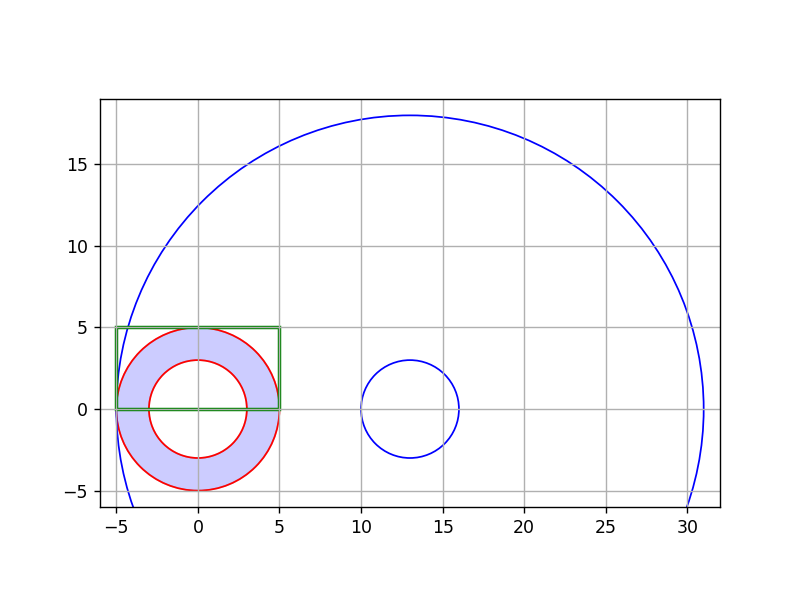

Площадь через алгоритм Монте-Карло = 25.12425
Приблизительное значение площади, посчитанная через shapely = 25.092387924367415
Точное значение площади 25.132741228718345


<IPython.core.display.Javascript object>


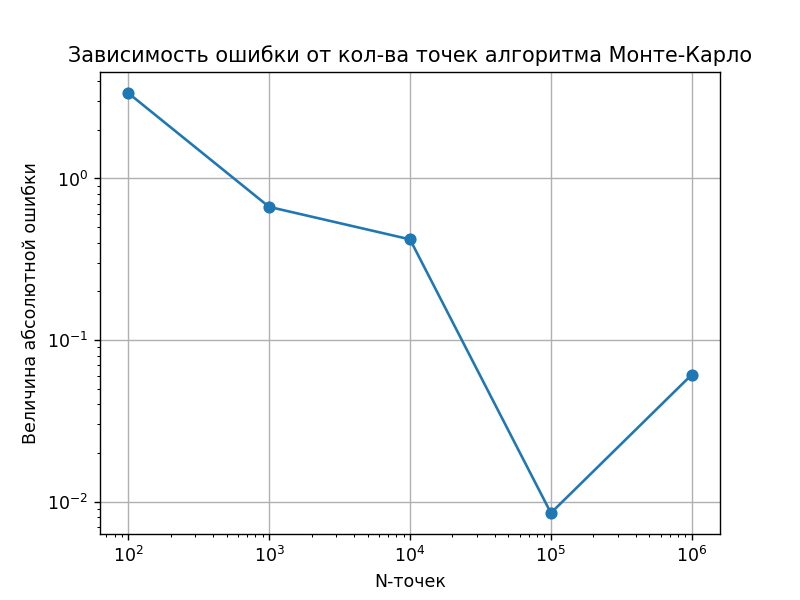

In [45]:
draw_and_compute(3,3,5,18,13)
print('Точное значение площади', (math.pi*25-math.pi*9)/2)
xx = [100, 1000, 10000, 100000, 1000000]
fig, ax = plt.subplots()
ax.loglog(xx, [abs(Monte_Carlo(3,3,5,18,13,p)[0]-(math.pi*25-math.pi*9)/2) for p in xx],'o-')
ax.set_title('Зависимость ошибки от кол-ва точек алгоритма Монте-Карло')
ax.set_xlabel('N-точек')
ax.set_ylabel('Величина абсолютной ошибки')
ax.grid()

<IPython.core.display.Javascript object>


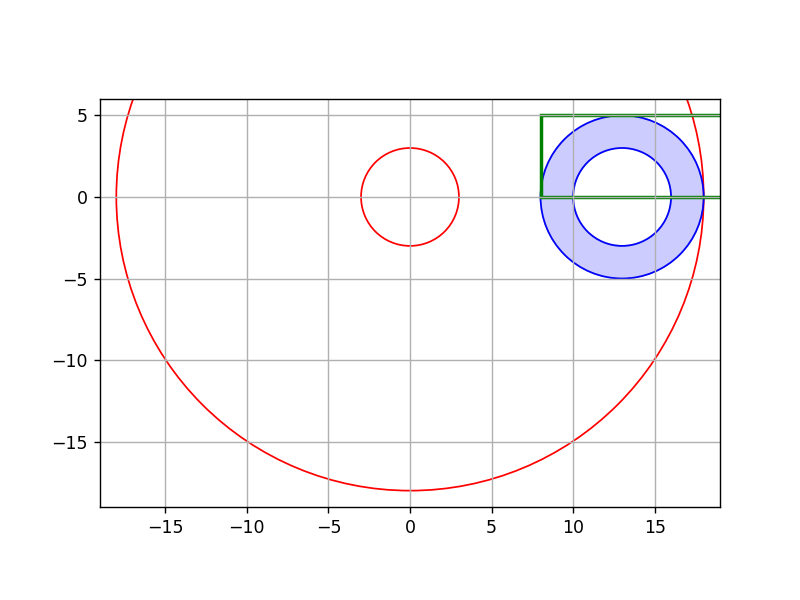

Площадь через алгоритм Монте-Карло = 25.3152
Приблизительное значение площади, посчитанная через shapely = 25.09238792436741
Точное значение площади 25.132741228718345


<IPython.core.display.Javascript object>


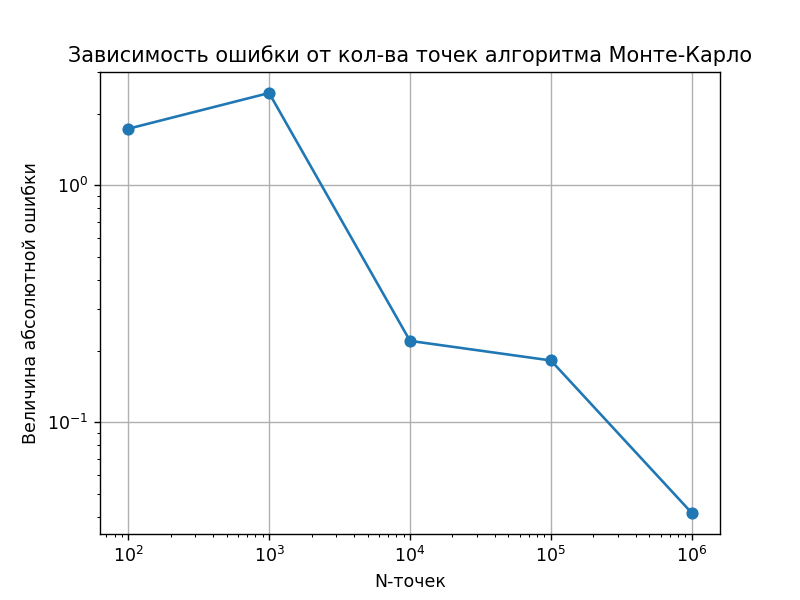

In [32]:
draw_and_compute(3,3,18,5,13)
print('Точное значение площади', (math.pi*25-math.pi*9)/2)
xx = [100, 1000, 10000, 100000, 1000000]
fig, ax = plt.subplots()
ax.loglog(xx, [abs(Monte_Carlo(3,3,18,5,13,p)[0]-(math.pi*25-math.pi*9)/2) for p in xx],'o-')
ax.set_title('Зависимость ошибки от кол-ва точек алгоритма Монте-Карло')
ax.set_xlabel('N-точек')
ax.set_ylabel('Величина абсолютной ошибки')
ax.grid()